# Activation Function

활성화 함수: 신경망에 비선형성을 추가하기 위해 필요

In [1]:
import json
import math
import os
import urllib.request
import warnings
from urllib.error import HTTPError

import matplotlib.pyplot as plt

%matplotlib inline
import matplotlib_inline.backend_inline
import numpy as np 
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from tqdm.notebook import tqdm

matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf") # For export
sns.set()

In [2]:
# 다운 받을 데이터셋 저장할 폴더 경로 
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")

# 사전 학습 모델 저장할 폴더 경로
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/Activation_Functions/")

# seed 정의 함수
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# GPU의 몇 개 연산은 효율을 높이기 위해 확률적으로 구현됨.
# 재현성을 위해 모든 연산이 GPU에서 결정론적으로 구현됨.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 이 노트북에서 사용할 장치
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("using device", device)

using device cuda:0


In [3]:
# 사용할 사전 학습 모델 다운 

# github url
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial3/"
# 다운 받을 파일
pretrained_files = [
    "FashionMNIST_elu.config",
    "FashionMNIST_elu.tar",
    "FashionMNIST_leakyrelu.config",
    "FashionMNIST_leakyrelu.tar",
    "FashionMNIST_relu.config",
    "FashionMNIST_relu.tar",
    "FashionMNIST_sigmoid.config",
    "FashionMNIST_sigmoid.tar",
    "FashionMNIST_swish.config",
    "FashionMNIST_swish.tar",
    "FashionMNIST_tanh.config",
    "FashionMNIST_tanh.tar",
]
# 파일이 존재하지 않는다면 체크포인트를 만든다.
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# 각 파일이 있는지 검사하고 없으면 다운 받는다.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e,)

### 일반적인 활성화 함수 ([참고](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity))

In [4]:
# 기본 클래스 생성
class ActivationFunction(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = self.__class__.__name__
        self.config = {"name": self.name}

In [5]:
# Sigmoid 함수
class Sigmoid(ActivationFunction):
    def forward(self, x):
        return 1 / (1 + torch.exp(-x))

# Tanh 함수
class Tanh(ActivationFunction):
    def forward(self, x):
        x_exp, neg_x_exp = torch.exp(x), torch.exp(-x)
        return (x_exp - neg_x_exp) / (x_exp + neg_x_exp)

In [6]:
# ReLU 함수
class ReLU(ActivationFunction):
    def forward(self, x):
        return x * (x > 0).float()

# LeakyReLU 함수
# 음수는 0이 되는 것 보완. 작은 기울기
class LeakyReLU(ActivationFunction):
    def __init__(self, alpha=0.1):
        super().__init__()
        self.config["alpha"] = alpha

    def forward(self, x):
        return torch.where(x > 0, x, self.config["alpha"] * x)

# ELU 함수
# 음수 부분 지수 감쇠로 대체
class ELU(ActivationFunction):
    def  forward(self, x):
        return torch.where(x > 0, x, torch.exp(x) - 1)

# Swish 함수
class Swish(ActivationFunction):
    def forward(self, x):
        return x * torch.sigmoid(x)

In [7]:
act_fn_by_name = {"Sigmoid": Sigmoid, "tanh": Tanh, "relu": ReLU, "Leakyrelu": LeakyReLU, "elu": ELU, "swish": Swish}

#### 활성화 함수 시각화

In [8]:
def get_grads(act_fn, x):
    """ 특정 위치에서 활성화 함수의 기울기 계산

    Args:
        act_fn: "ActivationFunction"의 객체
        x: 1차원 입력 tensor

    Returns:
        x의 act_fn의 기울기를 포함하는 x의 크기와 같은 tensor
    
    """
    x = x.clone().requires_grad_() #
    out = act_fn(x)
    out.sum().backward() # 

    return x.grad # x.grad를 통해 x의 기울기에 접근

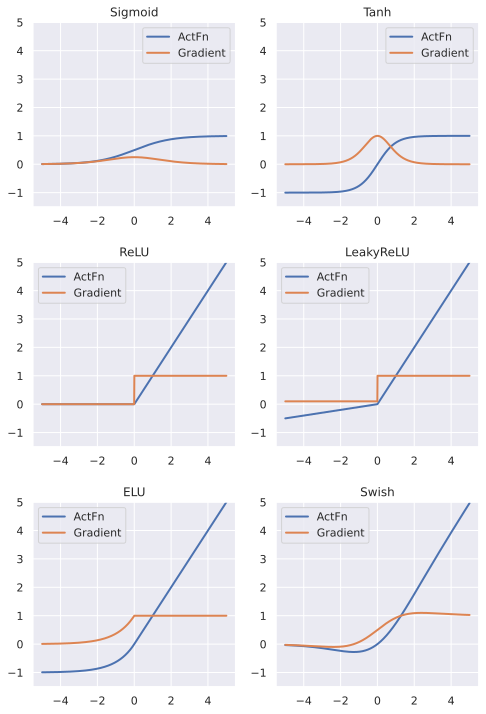

In [9]:
def vis_act_fn(act_fn, ax, x):
    # 활성화 함수 실행
    y = act_fn(x)
    y_grads = get_grads(act_fn, x)
    # x, y, 기울기를 cpu로 보낸다.
    x, y, y_grads = x.cpu().numpy(), y.cpu().numpy(), y_grads.cpu().numpy()
    # Plotting
    ax.plot(x, y, linewidth=2, label="ActFn")
    ax.plot(x, y_grads, linewidth=2, label="Gradient")
    ax.set_title(act_fn.name)
    ax.legend()
    ax.set_ylim(-1.5, x.max())

# 원하는 경우 활성화 함수 추가
act_fns = [act_fn() for act_fn in act_fn_by_name.values()]
x = torch.linspace(-5, 5, 1000) # 시각화 하고자하는 활성화 함수의 범위
# Plotting
cols = 2
rows = math.ceil(len(act_fns) / float(cols))
fig, ax = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
for i, act_fn in enumerate(act_fns):
    vis_act_fn(act_fn, ax[divmod(i, cols)], x)
fig.subplots_adjust(hspace=0.3)
plt.show()

#### 활성화 기능의 효과 분석

In [10]:
class BaseNetwork(nn.Module):
    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256,  128]):
        """ Base Network
        
        Args:
            act_fn: 활성화 함수의 개체......... 뭐라는거지
            input_size: 입력 이미지 픽셀 크기
            num_classes: 예측하고자 하는 클레스 숫자
            hidden_size: hidden layer 크기
        """
        super().__init__()

        # 명시된 hidden size에 기반한 네트워크 생성
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        layer_size_last = layer_sizes[0]
        for layer_size in layer_sizes[1:]:
            layers += [nn.Linear(layer_size_last, layer_size), act_fn]
            layer_size_last = layer_size
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        # nn.Sequential은 
        self.layers = nn.Sequential(*layers)

        # 모델 저장과 로드를 위해 모든 하이퍼파라미터를 딕셔너리에 저장한다.
        self.config = {
            "act_fn": act_fn.config,
            "input_size": input_size,
            "num_classes": num_classes,
            "hidden_sizes": hidden_sizes,
        }

    def forward(self, x):
        x = x.view(x.size(0), -1)   # 이미지를 벡터로 형태 변환한다.
        out = self.layers(x)
        return out

In [11]:
def _get_config_file(model_path, model_name):
    # 하이퍼파라미터 세부설명을 저장할 파일의 이름
    return os.path.join(model_path, model_name + ".config")

def _get_model_file(model_path, model_name):
    # 네트워크 파라미터 저장할 파일 이름
    return os.path.join(model_path, model_name + ".tar")

def load_model(model_path, model_name, net=None):
    """디스크에 저장된 모델 불러오기
    
    Args:
        model_path: 체크포인트 저장소의 경로
        model_name: 모델의 이름(str)
        net: (부가적) 상태 dict가 이 모델로 불러지며, 없을 경우 새로 만들어진다.
    """
    config_file, model_file = _get_config_file(model_path, model_name), _get_config_file(model_path, model_name)
    assert os.path.isfile(
        config_file
    ), f'Could not find the config file "{config_file}". Are you sure this is the correct path and you have your model config stored here?'
    assert os.path.isfile(
        model_file
    ), f'Could not find the model file "{model_file}". Are you sure this is the correct path and you have yourmodel stored here?'
    with open(config_file) as f:
        config_dict = json.load(f)
    if net is None:
        act_fn_name = config_dict["act_fn"].pop("name").lower()
        act_fn = act_fn_by_name[act_fn_name](**config_dict.pop("act_fn"))
        net = BaseNetwork(act_fn=act_fn, **config_dict)
    net.load_state_dict(torch.load(model_file, map_location=device))
    return net 

def save_model(model, model_path, model_name):
    """state_dict와 하이퍼파리미터를 저장한다.
    
    Args:
        model: 파라미터 저장할 네트워크 객체
        model_path: 체크포인트 폴더의 경로
        model_name: 모델의 이름 (Str)
    """
    config_dict = model.config
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    torch.save(model.state_dict(), model_file)

In [12]:
# => 텐서로 만들고 -1~1 사이로 정규화한다.
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# 훈련 데이터셋을 불러온다. 
train_dataet = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataet, [50000, 10000])

# 테스트셋을 가져온다.
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

100%|██████████| 26421880/26421880 [00:17<00:00, 1512990.65it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 104142.73it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:03<00:00, 1324243.19it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 25432599.52it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [13]:
train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

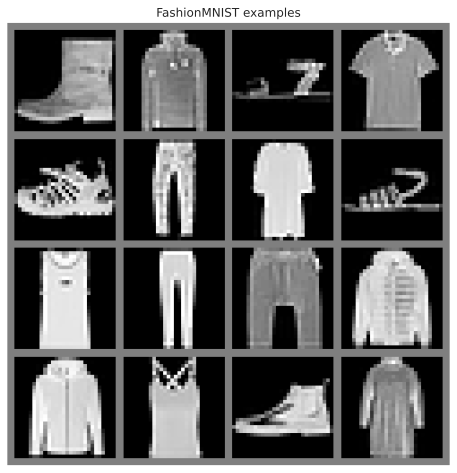

In [14]:
exmp_imgs = [train_set[i][0] for i in range(16)]
# 
img_grid = torchvision.utils.make_grid(torch.stack(exmp_imgs, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("FashionMNIST examples")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

#### 

활성화 함수: 네트워크를 통해 기울기를 전파할 수 있음.

In [15]:
def visualize_gradients(net, color="C0"):
    """기울기 시각화
    
    Args:
        net: BaeNetwork 클래스의 객체
        color: 히스토그램 시각화할 때 사용되는 색(활성화 함수의 구분을 쉽게 해준다.)
    """
    net.eval()
    small_loader = data.DataLoader(train_set, batch_size=256, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    # 네트워크에 하나의 배치를 통과시키고 가중치 기울기를 계산
    net.zero_grad()
    preds = net(imgs)
    loss = F.cross_entropy(preds, labels)
    loss.backward()
    # 가중치 매개변수만 시각화 하여 plot의 수를 줄인다.(편향 무시)
    grads = {
        name: params.grad.data.view(-1).cpu().clone().numpy()
        for name, params in net.named_parameters()
        if "weight" in name
    }
    net.zero_grad()

    # Plotting
    columns = len(grads)
    fig, ax = plt.subplots(1, columns, figsize=(columns * 3.5, 2.5))
    fig_index = 0
    for key in grads:
        key_ax =  ax[fig_index % columns]
        sns.histplot(data=grads[key], bins=30, ax=key_ax, color=color, kde=True)
        key_ax.set_title(str(key))
        key_ax.set_xlabel("Grad magnitude")
        fig_index += 1
    fig.suptitle(
        f"Gradient magnitude distribution for activation function {net.config['act_fn']['name']}", fontsize=14, y=1.05
    )
    fig.subplots_adjust(wspace=0.45)
    plt.show()
    plt.close()

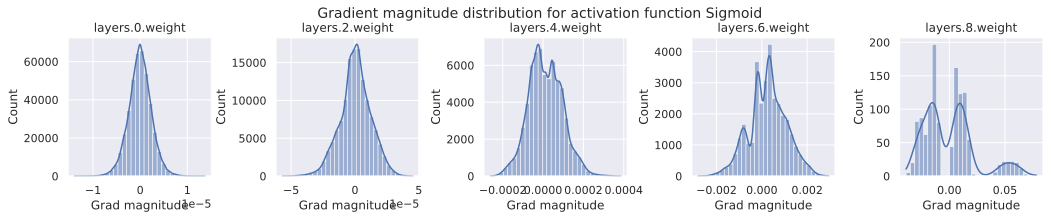

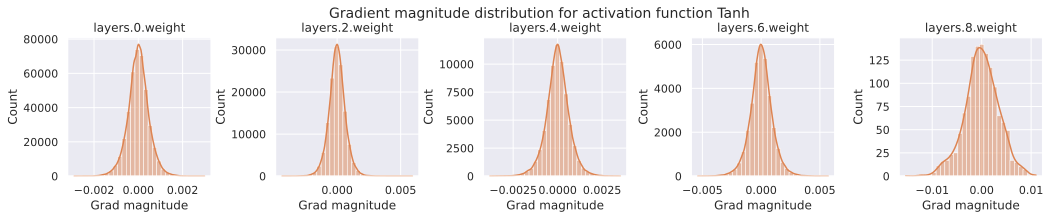

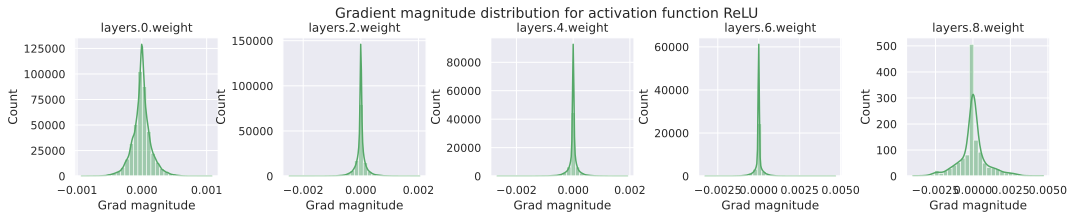

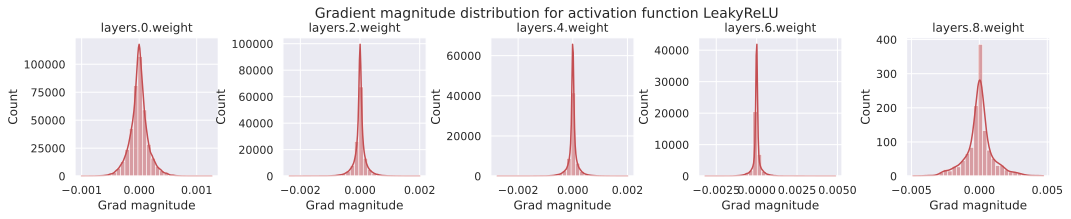

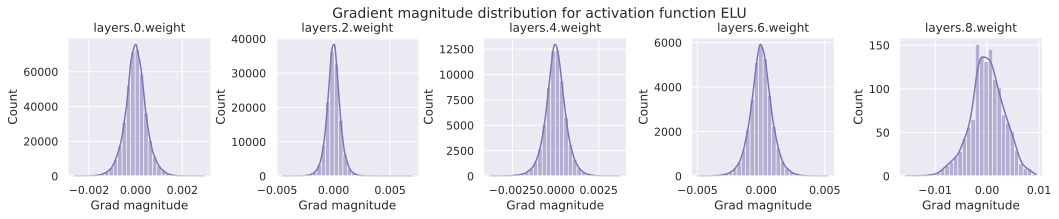

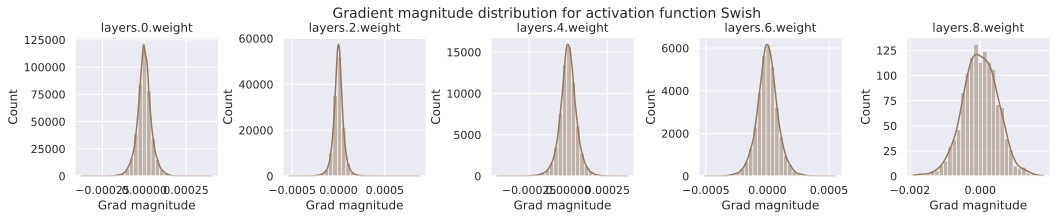

In [16]:
# Seaborn은 히스토그램이 작은 값을 가지면 경고하므로 무시하도록 한다.
warnings.filterwarnings("ignore")
# 모든 활성함수의 plot을 그린다.
for i , act_fn_name in enumerate(act_fn_by_name):
    # 각 활성화함수에 같은 가중치로 초기화하기 위해 seed 설정
    set_seed(42)
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn).to(device)
    visualize_gradients(net_actfn, color=f"C{i}")

#### 모델 학습

In [17]:
def train_model(net, model_name, max_epochs=50, patience=7, batch_size=256, overwrite=False):
    """FashionMNIST의 훈련 set로 모델 훈련
    
    Args:
        net: BaseNetwork의 객체
        model_name: (str)모델의 이름, 체크포인트 이름을 만들기 위해 사용되는.
        max_epochs: (최대로) 훈련이 반복되길 원하는 횟수
        patience: 검증set에서의 성능이 patience epoch 동안 개선되지 않는다면 훈련을 빠르게 끝낸다.
        batch_size: 훈련에서 사용하는 batch 크기
        overwrite: 체크포인트가 존재할 때, 처리 방법을 결정한다. 참이라면, 덮어쓰인다. 아니면, 훈련을 건너뛴다.
    """
    file_exists = os.path.isfile(_get_model_file(CHECKPOINT_PATH, model_name))
    if file_exists and not overwrite:
        print("Model file already exists. Skipping training...")
    else:
        if file_exists:
            print("Model file exists, but will be overwritten...")

        # 옵티마이저 정의, loss와 data loader
        optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9)  # 기본 parameters, 자유롭게 바꿔도 된다.
        loss_module = nn.CrossEntropyLoss()
        train_loader_local = data.DataLoader(
            train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True
        ) 

        val_scores = []
        best_val_epoch = -1
        for epoch in range(max_epochs):
            ############
            # Training #
            ############
            net.train()
            true_preds, count = 0.0, 0
            for imgs, labels in tqdm(train_loader_local, desc=f"Epoch {epoch+1}", leave=False):
                imgs, labels = imgs.to(device), labels.to(device) #GPU로
                optimizer.zero_grad()   # zero-grad는 "loss.backward()" 이전이면 어디든 위치 가능.
                preds = net(imgs)
                loss = loss_module(preds, labels)
                loss.backward()
                optimizer.step()
                # 훈련 동안 통계를 저장한다.
                true_preds += (preds.argmax(dim=-1) == labels).sum()
                count += labels.shape[0]
            train_acc = true_preds / count

            ##############
            # Validation #
            ##############
            val_acc = test_model(net, val_loader)
            val_scores.append(val_acc)
            print(
                f"[Epoch {epoch+1:2i}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%"
            )

            if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
                print("\t   (New best performance, saving model...)")
                save_model(net, CHECKPOINT_PATH, model_name)
                best_val_epoch = epoch
            elif best_val_epoch <= epoch - patience:
                print(f"Early stopping due to no improvement over the last {patience} epochs")
                break

        # validation 정확도의 곡선 plot
        plt.plot([i for i in range(1, len(val_scores) + 1)], val_scores)
        plt.xlabel("Epochs")
        plt.ylabel("Validation accuracy")
        plt.title(f"Validation performance of {model_name}")
        plt.show()
        plt.close()

    load_model(CHECKPOINT_PATH, model_name, net=net)
    test_acc = test_model(net, test_loader)
    print((f" Test accuracy: {test_acc*100.0:4.2f}% ").center(50, "=") + "\n")
    return test_acc


def test_model(net, data_loader):
    """특정 데이터셋으로 모델 평가
    
    Args:
        net: BaseNetwork의 훈련된 모델
        data_loader: 평가하는 데이터셋의 DataLoader 객체 (평가 또는 검증)
    """
    net.eval()
    true_preds, count = 0.0, 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1)
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = true_preds / count
    return test_acc

In [18]:
def train_model(net, model_name, max_epochs=50, patience=7, batch_size=256, overwrite=False):
    """Train a model on the training set of FashionMNIST.

    Args:
        net: Object of BaseNetwork
        model_name: (str) Name of the model, used for creating the checkpoint names
        max_epochs: Number of epochs we want to (maximally) train for
        patience: If the performance on the validation set has not improved for #patience epochs, we stop training early
        batch_size: Size of batches used in training
        overwrite: Determines how to handle the case when there already exists a checkpoint. If True, it will be overwritten. Otherwise, we skip training.
    """
    file_exists = os.path.isfile(_get_model_file(CHECKPOINT_PATH, model_name))
    if file_exists and not overwrite:
        print("Model file already exists. Skipping training...")
    else:
        if file_exists:
            print("Model file exists, but will be overwritten...")

        # Defining optimizer, loss and data loader
        optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9)  # Default parameters, feel free to change
        loss_module = nn.CrossEntropyLoss()
        train_loader_local = data.DataLoader(
            train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True
        )

        val_scores = []
        best_val_epoch = -1
        for epoch in range(max_epochs):
            ############
            # Training #
            ############
            net.train()
            true_preds, count = 0.0, 0
            for imgs, labels in tqdm(train_loader_local, desc=f"Epoch {epoch+1}", leave=False):
                imgs, labels = imgs.to(device), labels.to(device)  # To GPU
                optimizer.zero_grad()  # Zero-grad can be placed anywhere before "loss.backward()"
                preds = net(imgs)
                loss = loss_module(preds, labels)
                loss.backward()
                optimizer.step()
                # Record statistics during training
                true_preds += (preds.argmax(dim=-1) == labels).sum()
                count += labels.shape[0]
            train_acc = true_preds / count

            ##############
            # Validation #
            ##############
            val_acc = test_model(net, val_loader)
            val_scores.append(val_acc)
            print(
                f"[Epoch {epoch+1}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%"
            )

            if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
                print("\t   (New best performance, saving model...)")
                save_model(net, CHECKPOINT_PATH, model_name)
                best_val_epoch = epoch
            elif best_val_epoch <= epoch - patience:
                print(f"Early stopping due to no improvement over the last {patience} epochs")
                break

        # Plot a curve of the validation accuracy
        plt.plot([i for i in range(1, len(val_scores) + 1)], val_scores)
        plt.xlabel("Epochs")
        plt.ylabel("Validation accuracy")
        plt.title(f"Validation performance of {model_name}")
        plt.show()
        plt.close()

    load_model(CHECKPOINT_PATH, model_name, net=net)
    test_acc = test_model(net, test_loader)
    print((f" Test accuracy: {test_acc*100.0:4.2f}% ").center(50, "=") + "\n")
    return test_acc


def test_model(net, data_loader):
    """Test a model on a specified dataset.

    Args:
        net: Trained model of type BaseNetwork
        data_loader: DataLoader object of the dataset to test on (validation or test)
    """
    net.eval()
    true_preds, count = 0.0, 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1)
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = true_preds / count
    return test_acc

Training BaseNetwork with Sigmoid activation...


Epoch 1:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 1] Training accuracy: 09.96%, Validation accuracy: 10.74%
	   (New best performance, saving model...)


Epoch 2:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 2] Training accuracy: 09.91%, Validation accuracy: 09.99%


Epoch 3:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 3] Training accuracy: 10.10%, Validation accuracy: 09.85%


Epoch 4:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 4] Training accuracy: 10.02%, Validation accuracy: 10.74%


Epoch 5:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 5] Training accuracy: 10.16%, Validation accuracy: 10.32%


Epoch 6:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 6] Training accuracy: 10.12%, Validation accuracy: 10.74%


Epoch 7:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 7] Training accuracy: 10.03%, Validation accuracy: 10.27%


Epoch 8:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 8] Training accuracy: 10.12%, Validation accuracy: 09.45%
Early stopping due to no improvement over the last 7 epochs


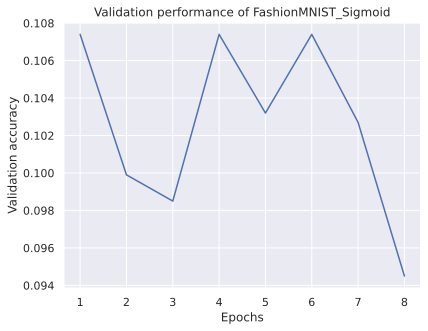

UnpicklingError: invalid load key, '{'.

In [19]:
for act_fn_name in act_fn_by_name:
    print(f"Training BaseNetwork with {act_fn_name} activation...")
    set_seed(42)
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn).to(device)
    train_model(net_actfn, f"FashionMNIST_{act_fn_name}", overwrite=False)

#### 활성화 분포 시각화

In [21]:
def visualize_activations(net, color="C0"):
    activations = {}

    net.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024)
    imgs, labels = next(iter(small_loader))
    with torch.no_grad():
        layer_index = 0
        imgs = imgs.to(device)
        imgs = imgs.view(imgs.size(0), -1)
        # We need to manually loop through the layers to save all activations
        for layer_index, layer in enumerate(net.layers[:-1]):
            imgs = layer(imgs)
            activations[layer_index] = imgs.view(-1).cpu().numpy()

    # Plotting
    columns = 4
    rows = math.ceil(len(activations) / columns)
    fig, ax = plt.subplots(rows, columns, figsize=(columns * 2.7, rows * 2.5))
    fig_index = 0
    for key in activations:
        key_ax = ax[fig_index // columns][fig_index % columns]
        sns.histplot(data=activations[key], bins=50, ax=key_ax, color=color, kde=True, stat="density")
        key_ax.set_title(f"Layer {key} - {net.layers[key].__class__.__name__}")
        fig_index += 1
    fig.suptitle(f"Activation distribution for activation function {net.config['act_fn']['name']}", fontsize=14)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()
    plt.close()

In [22]:
for i, act_fn_name in enumerate(act_fn_by_name):
    net_actfn = load_model(model_path=CHECKPOINT_PATH, model_name=f"FashionMNIST_{act_fn_name}").to(device)
    visualize_activations(net_actfn, color=f"C{i}")

KeyError: 'sigmoid'